# Fish disease diagnosis with MobileNetV2

## Setting up

In [73]:
%pip install tensorflow==2.16.0rc0 matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [74]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks, losses, optimizers, metrics
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as K
from tensorflow.keras.saving import save_model, load_model 
import seaborn as sns
from sklearn import metrics

## Configuration the parameters

In [75]:
input_shape = (224, 224, 3)
num_classes = 2

## Loading and pre-processing dataset

In [76]:
train_ds_path = '/kaggle/input/dataset/SalmonScan-split/train'
val_ds_path = '/kaggle/input/dataset/SalmonScan-split/val'
test_ds_path = '/kaggle/input/dataset/SalmonScan-split/test'

In [77]:
train_ds = image_dataset_from_directory(
    train_ds_path,
    label_mode="int",
    color_mode="rgb",
    image_size=(input_shape[0], input_shape[1]),
    shuffle=True,
    interpolation="bilinear",
    data_format='channels_last',
)

val_ds = image_dataset_from_directory(
    val_ds_path,
    label_mode="int",
    color_mode="rgb",
    image_size=(input_shape[0], input_shape[1]),
    shuffle=True,
    interpolation="bilinear",
    data_format='channels_last',
)

test_ds = image_dataset_from_directory(
    test_ds_path,
    label_mode="int",
    color_mode="rgb",
    image_size=(input_shape[0], input_shape[1]),
    shuffle=False,
    interpolation="bilinear",
    data_format='channels_last',
)

Found 724 files belonging to 2 classes.
Found 241 files belonging to 2 classes.
Found 243 files belonging to 2 classes.


In [78]:
data_preprocessing = keras.Sequential(
    [
        layers.Normalization(),
    ],
    name="data_preprocessing",
)

# Compute the mean and the variance of the training data for normalization.
unbatch_train_ds = train_ds.unbatch()
feature_ds = unbatch_train_ds.map(lambda x, y: x)
data_preprocessing.layers[0].adapt(feature_ds)

## Use data augmentation

In [79]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

## The MobileNetV2 Model

In [80]:
def create_mobilenet_classifier(optimizer, learning_rate, drop_out, weight_decay):
  # Load a pre-trained model
  pretrained_model = tf.keras.applications.MobileNetV2(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet"
  )

  # Implement transfer learning
  pretrained_model.trainable = False

  model = Sequential([
      data_preprocessing,
      #         data_augmentation,
      pretrained_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(num_classes, activation='softmax'),
  ])

  optimizer = optimizers.get(optimizer)
  optimizer.learning_rate = learning_rate
  optimizer.weight_decay = weight_decay

  loss = losses.SparseCategoricalCrossentropy()

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model

## Hyperparameters tuning

In [81]:
num_epochs = 1000

# configure test hyperparameters
tune_optimizers = ['rmsprop', 'adam', 'sgd']
tune_learning_rates = [0.001 ,0.01, 0.0001, 0.00001]
tune_dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
tune_weight_decays = [0.0001, 0.001, 0.00001, 0.000001]
tune_batch_sizes = [32, 16, 64, 128]

In [82]:
best_optimizer = tune_optimizers[0]
best_learning_rate = tune_learning_rates[0]
best_dropout = tune_dropouts[0]
best_batch_size = tune_batch_sizes[0]
best_weight_decay = tune_weight_decays[0]

In [83]:
def run_hyperparameters_tuning(optimizer=tune_optimizers[0], learning_rate=tune_learning_rates[0], dropout=tune_dropouts[0], batch_size=tune_batch_sizes[0], weight_decay=tune_weight_decays[0]):
  model = create_mobilenet_classifier(optimizer, learning_rate, dropout, weight_decay)

  train_ds.batch_size = batch_size
  val_ds.batch_size = batch_size
  test_ds.batch_size = batch_size

  history = model.fit(
      train_ds,
      epochs=num_epochs,
      verbose=0,
      callbacks=callbacks.EarlyStopping(
          monitor="val_loss", min_delta=0, patience=5, verbose=1,
          baseline=True, restore_best_weights=True, start_from_epoch=10
      ),
      validation_data=val_ds,
      shuffle=False,
  )

  metric_results = model.evaluate(val_ds, return_dict=True)

  return metric_results['accuracy']

In [84]:
print(f'Start hyperparameters tuning.............')

# Tuning optimizer
print('Tuning parameter: optimizer')
best_mean = 0
for optimizer in tune_optimizers:
  print(f'parameter: {optimizer}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=optimizer)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)
  
  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_optimizer = optimizer
  
  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best optimizer: {best_optimizer}')
print('\n')

# Tuning learning rate
print('Tuning parameter: learning rate')
best_mean = 0
for learning_rate in tune_learning_rates:
  print(f'parameter: {learning_rate}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=learning_rate)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)
  
  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_learning_rate = learning_rate
  
  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best learning rate: {best_learning_rate}')
print('\n')

# # Tuning dropout
# print('Tuning parameter: dropout')
# best_mean = 0
# for dropout in tune_dropouts:
#   print(f'parameter: {dropout}')
#   accuracies = np.array([])

#   for i in range(5):
#     accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=best_learning_rate, dropout=dropout)
#     print(f'loop {i} accuracy {accuracy}')
#     accuracies = np.concatenate((accuracies, [accuracy]),axis=0)
  
#   mean = np.mean(accuracies)
#   std = np.std(accuracies)

#   if mean > best_mean:
#     best_mean = mean
#     best_dropout = dropout
  
#   print(f'mean: {mean}')
#   print(f'std: {std}')
#   print('-----------------------------------------------------')
# print(f'Best dropout: {best_dropout}')
# print('\n')

# Tuning weight decay
print('Tuning parameter: weight decay')
best_mean = 0
for weight_decay in tune_weight_decays:
  print(f'parameter: {weight_decay}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=best_learning_rate, dropout=best_dropout, weight_decay=weight_decay)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)
  
  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_weight_decay = weight_decay
  
  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best weight decay: {best_weight_decay}')
print('\n')

# Tuning batch size
print('Tuning parameter: batch size')
best_mean = 0
for batch_size in tune_batch_sizes:
  print(f'parameter: {batch_size}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=best_learning_rate, dropout=best_dropout, weight_decay=best_weight_decay, batch_size=batch_size)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)
  
  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_batch_size = batch_size
  
  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best batch size: {best_batch_size}')
print('\n')

Start hyperparameters tuning.............
Tuning parameter: optimizer
parameter: rmsprop
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9612 - loss: 0.1199
loop 0 accuracy 0.9502074718475342
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9506 - loss: 0.1330
loop 1 accuracy 0.9502074718475342
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9430 - loss: 0.1129
loop 2 accuracy 0.9419087171554565
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9475 - loss: 0.1283
loop 3 accuracy 0.9502074718475342
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9582 -

## Compile, train and evaluate the model with best hyperparameters

In [153]:
!rm -r logs
!mkdir logs

In [154]:
csv_logger_filepath = 'logs/result.csv'
save_model_filpath = 'logs/mobilenetv2.keras'

In [155]:
# Call back
csv_logger = callbacks.CSVLogger(
    csv_logger_filepath,
    separator=",",
    append=True
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=True,
    restore_best_weights=True,
    start_from_epoch=10,
)

def run_experiment(model, batch_size, num_epochs):
    
    train_ds.batch_size = batch_size
    val_ds.batch_size = batch_size
    test_ds.batch_size = batch_size
    
    history = model.fit(
        train_ds,
        epochs=num_epochs,
        callbacks=[
            csv_logger, early_stopping
        ],
        validation_data=val_ds,
        shuffle=False,
    )

    save_model(model, save_model_filpath, overwrite=True)
    
    # Evaluate the model
    metric_results = model.evaluate(test_ds, return_dict=True )
    print(f"Test accuracy: {round(metric_results['accuracy'] * 100, 2)}%")
    
    return history, model

In [156]:
print(best_learning_rate)
print(best_optimizer)
print(best_dropout)
print(best_batch_size)
print(best_weight_decay)

0.001
rmsprop
0.1
32
1e-06


In [157]:
model = create_mobilenet_classifier(best_optimizer, best_learning_rate, best_dropout, best_weight_decay)
history, model = run_experiment(model, best_batch_size, num_epochs)

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.7213 - loss: 0.6294 - val_accuracy: 0.9170 - val_loss: 0.3121
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8724 - loss: 0.3284 - val_accuracy: 0.9253 - val_loss: 0.2184
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8918 - loss: 0.2393 - val_accuracy: 0.9336 - val_loss: 0.1964
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9204 - loss: 0.2104 - val_accuracy: 0.9336 - val_loss: 0.1889
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9335 - loss: 0.1741 - val_accuracy: 0.9253 - val_loss: 0.1847
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9536 - loss: 0.1571 - val_accuracy: 0.9378 - val_loss: 0.1669
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9516 - loss: 0.1366 - val_accuracy: 0.9419 - val_loss: 0.1525
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9614 - loss: 0.1308 - val_ac

In [158]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

unbatch_test_ds = test_ds.unbatch()    
true_labels = list(unbatch_test_ds.map(lambda x, y: y))
predicted_labels = model.predict(test_ds).argmax(axis=-1)

print(predicted_labels)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


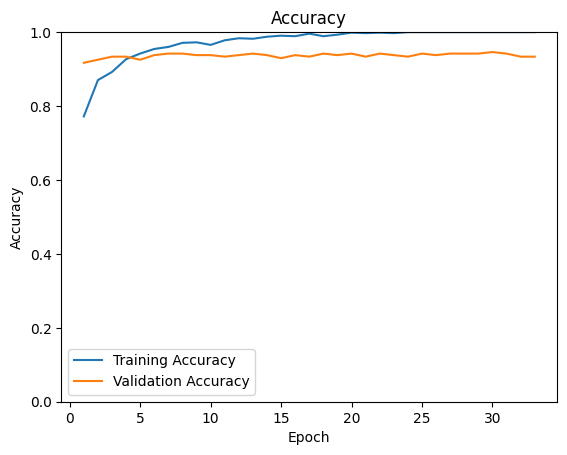

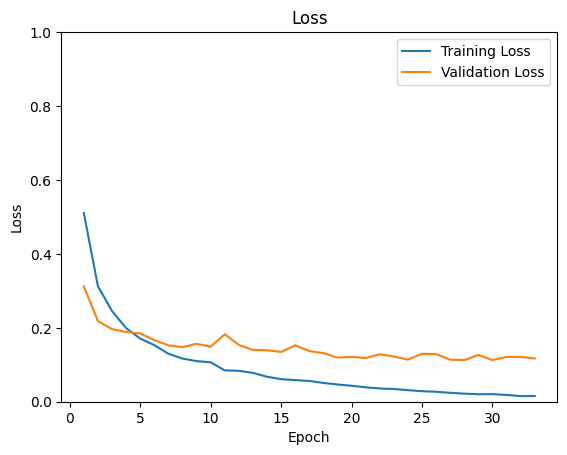

              precision    recall  f1-score   support

           0     0.9032    0.9130    0.9081        92
           1     0.9467    0.9404    0.9435       151

    accuracy                         0.9300       243
   macro avg     0.9249    0.9267    0.9258       243
weighted avg     0.9302    0.9300    0.9301       243



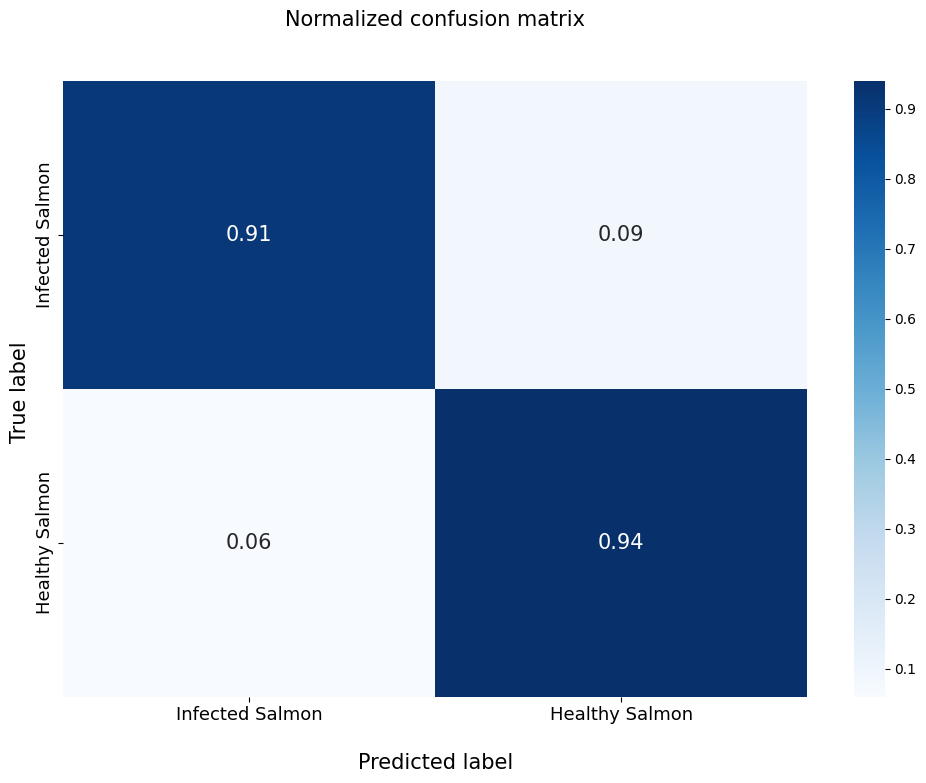

In [159]:
plt.axis(ymin=0.0, ymax=1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('logs/accuracy.png')
plt.show()

plt.axis(ymin=0.0, ymax=1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('logs/loss.png')
plt.show()

report = metrics.classification_report(true_labels,predicted_labels, digits=4)
print(report)

cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()
ncm = np.round(cm/np.sum(cm, axis=1).reshape(-1,1),2)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(ncm, annot=True, cmap='Blues', fmt='g', annot_kws={"size":15})
ax.set_title('Normalized confusion matrix\n\n', fontsize=15);
ax.set_xlabel('\nPredicted label', fontsize=15)
ax.set_ylabel('True label ', fontsize=15);
ax.xaxis.set_ticklabels(['Infected Salmon','Healthy Salmon'], fontsize=13)
ax.yaxis.set_ticklabels(['Infected Salmon','Healthy Salmon'], fontsize=13)
plt.savefig('logs/normalized_confusion_atrix.png')
plt.show()

In [160]:
!rm -f logs.zip
!zip -r logs.zip logs

  adding: logs/ (stored 0%)
  adding: logs/accuracy.png (deflated 13%)
  adding: logs/loss.png (deflated 12%)
  adding: logs/mobilenetv2.keras (deflated 12%)
  adding: logs/normalized_confusion_atrix.png (deflated 19%)
  adding: logs/result.csv (deflated 59%)
